In [34]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from pydataset import data

144


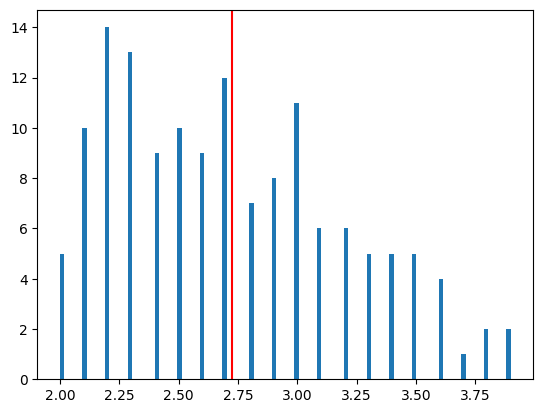

In [35]:
nums_orig = data('cats').Bwt  #body weight of a bunch of cats
print(len(nums_orig))

plt.hist(nums_orig,bins=100)
plt.axvline(x=nums_orig.mean(), color='r')
plt.show()



In [36]:
#compute std error of the mean to get confidence intervals 
# on mean from a sample using closed form estimate
N=50

def sample_mean_std(buf, N):
    samp = np.random.choice(buf, size=N)
    mean = samp.mean()
    mean_diff = samp-mean
    s = (np.sum(np.power(mean_diff, 2)) / N)
    std_dev_est = math.sqrt(s)/math.sqrt(N)
    return (mean, std_dev_est)

(u,std) = sample_mean_std(nums_orig, N)
true_u=nums_orig.mean()
print("true mean=%.2f, est. mean=%.2f, 95%%ci = (%.2f, %.2f)"%(true_u, u, u-2*std, u+2*std))

true mean=2.72, est. mean=2.67, 95%ci = (2.54, 2.80)


hit 94.14% of samples


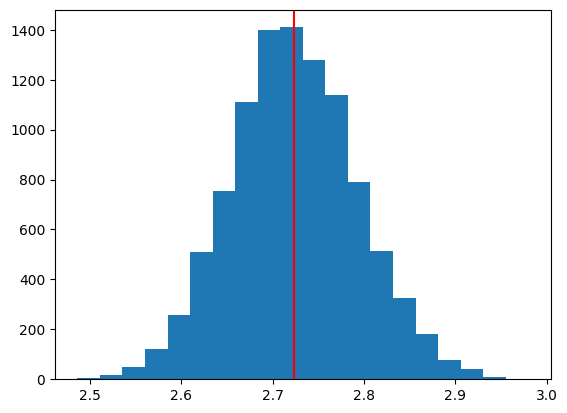

In [37]:
hit = 0
means = []

for i in range(0,10000):
    (u,std) = sample_mean_std(nums_orig, N)
    err = np.abs(u - true_u)
    success = err < 2 * std
    if (success):
        hit = hit + 1
    means.append(u)

print("hit %.2f%% of samples"%(hit/10000.0 * 100))
plt.hist(means,bins=20)
plt.axvline(x=nums_orig.mean(), color='r')



true median=2.70
bootstrap median=2.60, 2.95


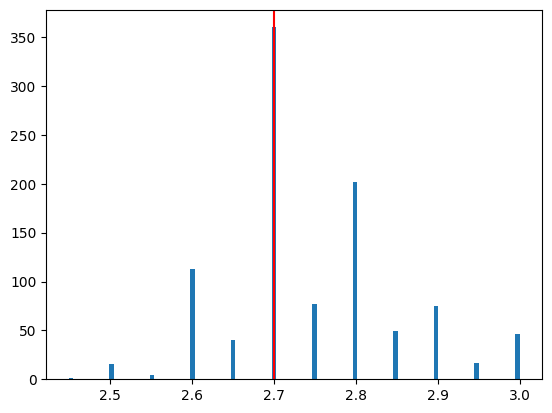

true mean=2.72
bootstrap mean=2.70, 2.85


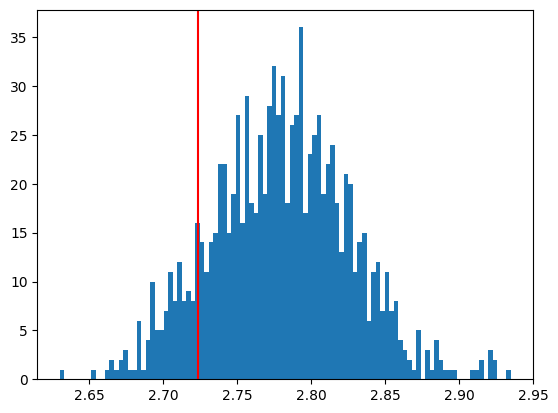

In [38]:
# use bootstrap to get confidence intervals
# on arbitrary functions 
N_boots = 1000
N = 100

def bootstrap(buf, fn, n_boots,ci,samp_size=N):
    vals = []
    buf_s = np.random.choice(buf,size=samp_size)
    for i in range(0,n_boots):
        samp = np.random.choice(buf_s, size=samp_size, replace=True)
        vals.append(fn(samp))
    return(np.percentile(vals,ci), np.percentile(vals,100.0-ci), vals)


print("true median=%.2f"%(np.median(nums_orig)))
(ci1, ci2, vals) = bootstrap(nums_orig,np.median,N_boots,5.0)
print("bootstrap median=%.2f, %.2f"%(ci1, ci2))
plt.hist(vals,bins=100)
plt.axvline(x=nums_orig.median(), color='r')
plt.show()


print("true mean=%.2f"%(true_u))
(ci1, ci2, vals) = bootstrap(nums_orig,np.mean,N_boots,5.0)
print("bootstrap mean=%.2f, %.2f"%(ci1, ci2))
plt.hist(vals,bins=100)
plt.axvline(x=nums_orig.mean(), color='r')
plt.show()



In [39]:
#hyperloglog
import hyperloglog
from faker import Faker

error_rate = 0.05
hll = hyperloglog.HyperLogLog(error_rate)  
p = int(math.ceil(math.log((1.04 / error_rate) ** 2, 2)))

#note that the number of buckets is independent of the dataset size
print("%d buckets needed"%(1 << p))

# 100 distinct fake names
fake = Faker()
ns = []
for i in range(0,100):
    ns.append(fake.name().encode('utf-8'))
print(ns[0:3])

#10000 sample
samps = np.random.choice(ns, size=10000, replace=True)
for s in samps:
    hll.add(s)
print(len(hll))

512 buckets needed
[b'Monica Summers', b'Shelly Young', b'Nicole Flores']
104


In [40]:

import hashlib
def count_lead_zeroes(d,b):
    # https://graphics.stanford.edu/~seander/bithacks.html#ZerosOnRightLinear
    #print bin(d)
    if d:
        leading = b
        v = d
        while v:
            v >>= 1
            leading -= 1
        #print bin(d)
        #print leading
        return leading + 1
    return b

nbits = 64

def int_hash(s):
    h = hashlib.sha1(s)
    return h.hexdigest()[:nbits//4]

def get_first(s,i):
    part = s[0:i//4]
    return int(part,16)

def get_last(s,i):
    offset = i//4
    part = s[offset:]
    return int(part,16)



In [41]:
bucket_bits = 8
buckets = int(math.pow(2, bucket_bits))
print(buckets)

hashes = []
for name in ns:
    h = int_hash(name)
    hashes.append(h)

samps = np.random.choice(hashes, size=10000, replace=True)


256


In [42]:

def get_alpha(p):
    if not (4 <= p <= 16):
        raise ValueError("p=%d should be in range [4 : 16]" % p)

    if p == 4:
        return 0.673

    if p == 5:
        return 0.697

    if p == 6:
        return 0.709

    return 0.7213 / (1.0 + 1.079 / (1 << p))


In [43]:
#wikipedia algorithm https://en.wikipedia.org/wiki/HyperLogLog
mx = np.zeros(buckets)

for s in samps:
    i = get_first(s,bucket_bits)
    j = get_last(s,bucket_bits)
    
    nzeros = count_lead_zeroes(j, nbits - bucket_bits)
    if (nzeros > mx[i]):
        mx[i] = nzeros
sum = 0

#compute the harmonic mean of the registers
for i in range(0,buckets):
    exp = math.pow(2.0, -mx[i])
    sum = sum + exp
sum = 1/sum

E = sum * buckets**2 * get_alpha(bucket_bits)

zeros = len(mx) - np.count_nonzero(mx) 
if (zeros > 0 and E < 2.5 * buckets):
    H = buckets * math.log(buckets / float(zeros))
    print(int(round(H)))
else:
    print(int(round(E)))




99


In [44]:
# count min
# see https://medium.com/@amirziai/count-min-sketch-4b0ab93bb37a
from dataclasses import dataclass
import mmh3  # pip install mmh3


@dataclass
class CountMinSketch:
    tables: int
    buckets: int
        
    def __post_init__(self):
        self.x = np.zeros((self.tables, self.buckets))
    
    def increment(self, x: str) -> None:
        for table_idx in range(self.tables):
            b = self._get_bucket(x=x, table_idx=table_idx)
            self.x[table_idx, b] += 1
    
    def count(self, x: str) -> int:
        return min(
            self.x[table_idx, self._get_bucket(x=x, table_idx=table_idx)]
            for table_idx in range(self.tables)
        )
    
    def _get_bucket(self, x: str, table_idx: int) -> int:
        b = mmh3.hash(key=x, seed=table_idx, signed=False) % self.buckets
        #print(f"b = {b}, x = {x}, t={table_idx}")
        #freqs[b] = freqs[b] + 1
        return b


In [45]:
#create synthetic data -- uuid's that appear with a skewed frequency
from uuid import uuid4
import pandas as pd
data3 = []

target = 100000  # total number of values
inc = 100 # skew -- adjust maximum number of repeats of each value by this amount on each new iteration
i = 100
t = 2
b = 50
#freqs = np.zeros(b)
while len(data3) < target:
    i += inc
    diff = target - len(data3)
    n = np.random.randint(1, min(diff, i) + 1)
    data3.extend([str(uuid4())] * n)

counts_actual = pd.Series(data3).value_counts()
cms = CountMinSketch(tables=t, buckets=b)
for x in data3: cms.increment(x)
#print(freqs)

In [46]:
counts_cms = pd.Series(
    (cms.count(x) for x in set(data3)),
    index=set(data3),
).sort_values(ascending=False)
#counts_cms
#print(len(counts_cms))

                                      cnt_cms  cnt_actual
index                                                    
961b29e0-ed5a-4898-ab36-df327e21eb2c   8473.0        4145
c5b63f9c-9a27-499d-86ad-0f2239decb5b   8473.0        3558
a2c16d49-016e-4064-9e8d-81b967bc7fbf   5532.0        1452
ed7b6de0-6ae8-4589-a8c1-598b002a6498   5532.0        1310
6fdc273c-77f0-4938-83bf-7d42fa9a6ddd   5532.0        2739
26e5fa02-361c-4604-ab2d-d9b862593d5d   5507.0        5444
d9f07770-6071-4742-ab9a-0d5e078fe4a3   5441.0        4131
22b1ad6d-0cee-4a26-ad19-ee8a46c8c526   5367.0        1769
700cb033-25d1-49ef-8475-e18b75ca463f   5038.0        2000
c79785b9-015e-4424-b64f-0304b919fa1a   5038.0        3038
1f6c3384-6287-4b9f-9520-92475dfc1d25   4834.0         956
f78cb45d-4594-429c-bb66-ea2d5e3671af   4834.0        3878
bf245603-3170-493e-9170-121c38ab4f22   4544.0        4544
1a44db91-85d1-4855-b617-f5576a13036c   4323.0        1307
18c229e2-b9b8-4235-84dc-d1b59746f027   4323.0        3016
7f25e409-4db5-

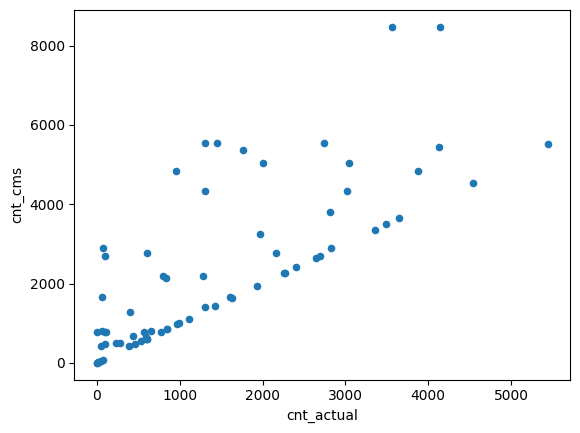

In [47]:
cnts = counts_cms.to_frame('cnt_cms').reset_index().merge(
        counts_actual
        .to_frame('cnt_actual')
        .reset_index()
    ).set_index('index')
#print(cnts)
cnts.plot.scatter(x='cnt_actual', y='cnt_cms')
print(cnts.head(100))
print (cms.x)

t=1, b=100: 	 out of top 10, 4 shared
t=2, b=50: 	 out of top 10, 5 shared
t=3, b=33: 	 out of top 10, 6 shared
t=4, b=25: 	 out of top 10, 6 shared
t=5, b=20: 	 out of top 10, 6 shared


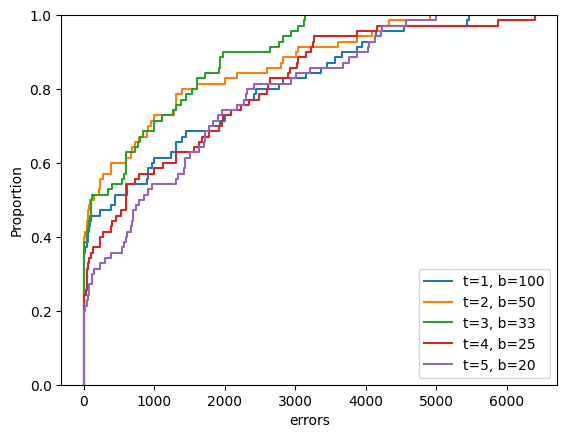

In [48]:
import seaborn as sns
nbuck = 100
topn = 10
for (tables,buckets) in ((1,int(nbuck)), (2,int(nbuck/2)), (3, int(nbuck/3)), (4, int(nbuck/4)), (5, int(nbuck/5))):
    cms = CountMinSketch(tables=tables, buckets=buckets)
    for x in data3: cms.increment(x)
    counts_cms = pd.Series(
        (cms.count(x) for x in set(data3)),
        index=set(data3),
    ).sort_values(ascending=False)
    cnts = counts_cms.to_frame('cnt_cms').reset_index().merge(
            counts_actual
            .to_frame('cnt_actual')
            .reset_index()
        ).set_index('index')
    cnts["errors"] = (cnts.cnt_cms - cnts.cnt_actual)#/cnts.cnt_actual
    sns.ecdfplot(cnts.errors, label=f"t={tables}, b={buckets}")
    topk_actual = cnts.cnt_actual.sort_values(ascending=False).head(topn)
    topk_cms = cnts.cnt_cms.head(topn)
    merged = pd.Series(list(set(topk_actual.index) & set(topk_cms.index)))
    print(f"t={tables}, b={buckets}: \t out of top {topn}, {len(merged)} shared")

    
plt.legend()
plt.show()
